# Linear Regresion - comparison of model using entire dataset and multiple models.

Based in previous Jupyter Notebook: Database Connection - Linear Regression - Spliting dataset into Train and Test sets

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:

`$   pip install psycopg2`

`$   pip install psycopg2-binary `

In [1]:
%matplotlib inline

In [2]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [3]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [4]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# List tables in database
inspect(engine).get_table_names()

['high_low_poverty',
 'ave_wage_indexing',
 'welfare_education',
 'economic_features_full',
 'economic_features',
 'lowest_poverty_rates',
 'highest_poverty_rates',
 'cpi_inflation_rate',
 'crime_rate',
 'divorce_rate',
 'homeownership_rate',
 'min_wage_effective',
 'poverty_rates',
 'unemployment_rate']

In [7]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [8]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [9]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [10]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [13]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million','population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
0,1970,National,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18,277.695251,92.172236
1,1971,National,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05,308.829039,133.149892
2,1972,National,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12,343.443144,147.263564
3,1973,National,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13,361.163357,137.824325
4,1974,National,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86,383.609909,163.997004


## Model using entire dataset

In [31]:
m_df = model_df.dropna().set_index('year')
m_temp_df = m_df.copy()
m_df.drop(columns=['state'], inplace=True)
m_df

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1984,539.2,7.637412,4.9778,64.5,3.360196,103.900,4.3,16135.07,16.04,816.132571,611.113521
1985,556.6,7.304109,4.9222,63.9,3.360196,107.600,3.5,16822.51,15.72,881.441974,696.980650
1986,620.1,7.096872,4.8667,63.8,3.360196,109.600,1.9,17321.82,15.20,950.374590,663.830213
1987,609.7,6.297189,4.8111,64.0,3.360196,113.600,3.7,18426.51,14.48,1003.522961,691.828549
1988,637.2,5.589161,4.7556,63.8,3.409804,118.300,4.1,19334.04,14.81,1065.191922,724.515997
...,...,...,...,...,...,...,...,...,...,...,...
2010,197.9,6.900000,3.6000,73.4,7.250000,218.056,1.6,41673.83,8.80,4434.690265,856.637168
2011,219.4,6.200000,3.6000,71.1,7.250000,224.939,3.2,42979.61,9.10,4462.786596,753.791887
2012,201.3,5.500000,3.4000,70.3,7.250000,229.594,2.1,44321.67,9.40,4631.715771,661.178510


In [16]:
# Define X and y variables
X = m_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = m_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (1586, 10)


,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
1984,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,816.132571,611.113521
1985,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,881.441974,696.980650
1986,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,950.374590,663.830213
1987,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,1003.522961,691.828549
1988,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,1065.191922,724.515997


In [18]:
# Create a model with scikit-learn
model = LinearRegression()
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [19]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)

# Use y_pred_test to plot testing points
y_pred_test = model.predict(X_test)

(1586,)
(1586, 10)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 2.194196001653515
Mean square error: 9.031844438558535
r2 score: 0.5095301005361595
Coefficients: [ 2.66505038e-03  1.22589207e+00 -4.28101625e+00 -2.49178386e-01
  7.50443581e-02 -5.66770420e-02  4.97050342e-01  3.92829347e-05
 -1.95744854e-03 -3.66012999e-03]
Intercept: 53.813854651853376


# R2 score of entire dataset with 80/20 split in Train/Test is 0.51
# Now let's see how a few individual plots look.

In [33]:
m_temp_df['predicted_poverty'] = y_pred
#m_df['state']=model_df.dropna()['state']
m_temp_df.head()

,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,,
1984,National,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,16.04,816.132571,611.113521,20.531720
1985,National,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,15.72,881.441974,696.980650,19.534565
1986,National,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,15.20,950.374590,663.830213,18.809642
1987,National,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,14.48,1003.522961,691.828549,18.494654
1988,National,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,14.81,1065.191922,724.515997,17.718867


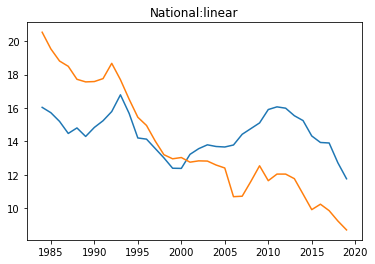

In [37]:
state = 'National'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

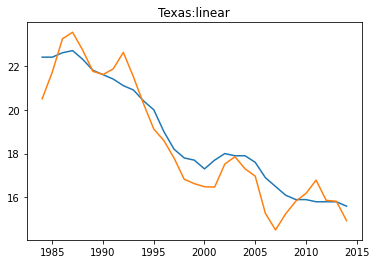

In [38]:
state = 'Texas'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

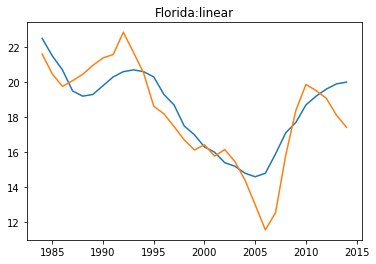

In [39]:
state = 'Florida'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

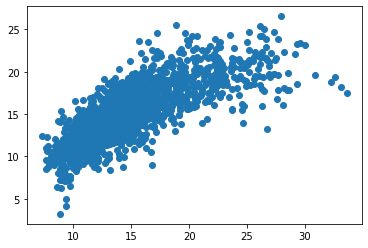

In [41]:
plt.scatter(m_temp_df['poverty_rate'], m_temp_df['predicted_poverty'])

## Comments:  Poor R2 Score overall,  individual states don't look good.  Expect forecasting to be poor.


## Model for 1 state.  Start with National.  I used 90/10 split as there are not many points to train.

In [55]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Michigan', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'New Jersey', 'Nevada', 'New Hampshire', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [124]:
# Pick data for 1 state
state_to_model = 'National'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df.head()

# Define X and y variables
X1 = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y1 = model_state_df["poverty_rate"]
print(f'X shape: {X1.shape}')
X1.head()

X shape: (36, 10)


,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
1984,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,816.132571,611.113521
1985,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,881.441974,696.980650
1986,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,950.374590,663.830213
1987,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,1003.522961,691.828549
1988,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,1065.191922,724.515997


In [117]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [125]:
##
# Create a model with scikit-learn
model1 = LinearRegression()


# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X1, y1, train_size=0.8)
model1.fit(X_train, y_train)

LinearRegression()

In [119]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
#model.fit(X, y)

In [126]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model1.predict(X1)
print(y_pred.shape)
print(X1.shape)

# Use y_pred_test to plot testing points
y_pred_test = model1.predict(X_test)

(36,)
(36, 10)


In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model1.coef_}')
print(f'Intercept: {model1.intercept_}')
print(f'Features: {X1.columns}')

Mean absolute error: 1.5031658283946137
Mean square error: 3.3728753250517483
r2 score: 0.5127627036334444
Coefficients: [ 1.58483089e-02  1.25027329e+00 -5.22002085e+00 -1.24840536e-02
  1.22919345e+00  2.36915792e-01  2.11968903e-01 -9.78803892e-04
 -8.78363300e-03 -4.62532768e-03]
Intercept: 30.716436466969455
Features: Index(['crime_rate', 'unemployment_rate', 'divorce_rate_per_1000_people',
       'homeownership_rate', 'minimum_wage_effective', 'cpi_average',
       'inflation_rate', 'avg_wage_index', 'education_per_capita',
       'welfare_per_capita'],
      dtype='object')


In [127]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,
1984,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,16.04,816.132571,611.113521,16.078670
1985,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,15.72,881.441974,696.980650,15.718827
1986,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,15.20,950.374590,663.830213,15.162462
1987,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,14.48,1003.522961,691.828549,14.799399
1988,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,14.81,1065.191922,724.515997,14.320709


In [114]:
X_test

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
2000,243.8,4.2,4.0000,55.2,5.25,172.200,3.4,32154.82,1531.353135,636.633663
2013,254.4,4.8,3.3000,57.3,7.25,232.957,1.5,44888.16,2426.898510,745.422285
2005,255.5,2.8,3.6000,59.8,6.25,195.300,3.4,36952.94,2115.797788,598.104265
1999,234.9,5.2,4.1000,56.6,5.25,166.600,2.2,30469.84,1484.346378,578.184846
1988,257.1,3.1,4.7556,53.2,3.85,118.300,4.1,19334.04,835.714286,421.150278
1989,270.1,2.5,4.7000,54.7,3.85,124.000,4.8,20099.55,921.957914,459.926807
1996,280.6,5.9,4.3571,50.6,5.25,156.900,2.9,25913.90,1345.936698,818.391788


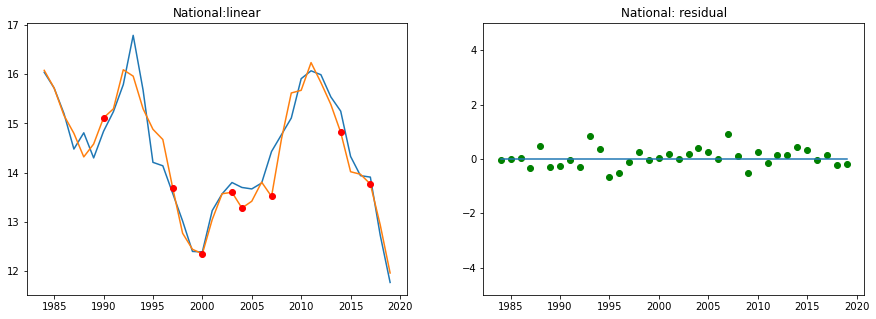

In [128]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
ax[0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
ax[0].set_title(f'{state_to_model}:linear')

ax[1].plot(model_state_df.index.values, (model_state_df['poverty_rate']-model_state_df['predicted_poverty']),
          color='g', marker='o', lw=0)
ax[1].set_title(f'{state_to_model}: residual')
ax[1].set_ylim([-5,5])
ax[1].plot([model_state_df.index.values.min(),model_state_df.index.values.max()],[0,0])
plt.show()

#plt.plot(X, y_pred, color='red')
#plt.show()

In [66]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[ 2.66505038e-03  1.22589207e+00 -4.28101625e+00 -2.49178386e-01
  7.50443581e-02 -5.66770420e-02  4.97050342e-01  3.92829347e-05
 -1.95744854e-03 -3.66012999e-03]
53.813854651853376


## Create Function

In [143]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_model(df, model_type='linear'):
    training_size = 0.8
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots,2 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        if model_type=='linear':
            model = LinearRegression()
        elif model_type =='ridge':
            model = Ridge(alpha=0.5)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
        else:
            model = LinearRegression()
    
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        model.fit(X_train, y_train)
    
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        m_df['predicted_poverty'] = y_pred
    
    # Use y_pred_test to plot testing points
        y_pred_test = model.predict(X_test)
        r2s = r2_score(y_test,y_pred_test)
    #m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
        ax[row][0].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty'])
        ax[row][0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
        ax[row][0].set_title(f'{state}: r2 score:{r2s:.3f}')
        
        ax[row][1].plot(m_df.index.values,(m_df['poverty_rate']-m_df['predicted_poverty']),color='g', marker='o', lw=0)
        ax[row][1].set_title(f'{state}: residual')
        ax[row][1].set_ylim([-5,5])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[0,0])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[1,1], color='r')
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[-1,-1], color='r')
    
        result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error': mean_squared_error(y_test,y_pred_test),
                    'r2 score': r2s,
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

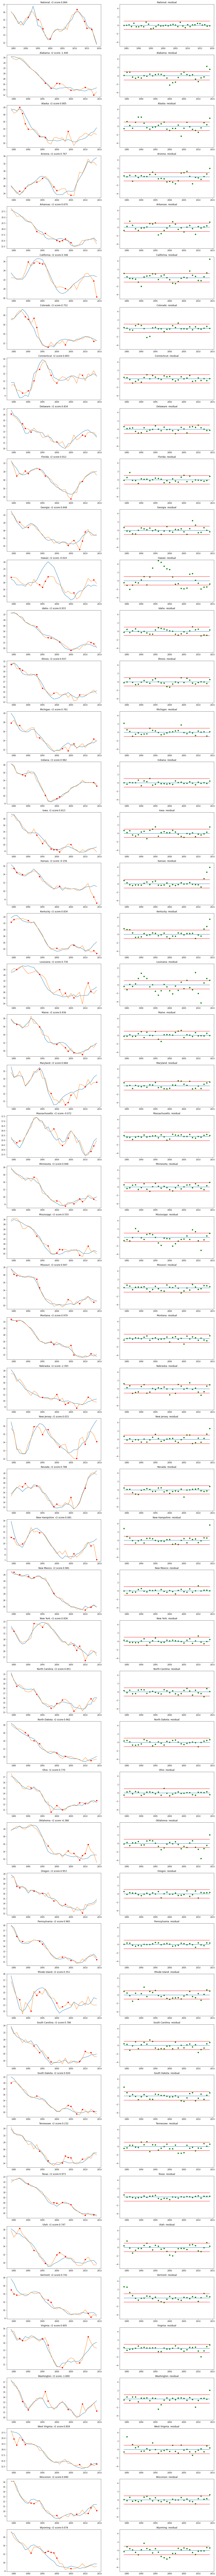

In [144]:
result_df = pd.DataFrame()

result = run_model(model_df, 'linear')
result_df = result_df.append(result, ignore_index=True)


In [145]:
result_df.sort_values(by='r2 score', ascending=False)

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,State,r2 score
15,"[-0.0012755733852360886, 1.1005505491083964, 0...",41.182956,0.281776,0.117485,linear,Indiana,0.982359
31,"[0.0014457969461278565, 0.3470616708205511, 4....",6.020462,0.482256,0.354392,linear,New Mexico,0.980869
26,"[0.0024051832110838995, 0.936835562205123, -8....",85.335578,0.443652,0.352025,linear,Montana,0.978738
43,"[-0.001651198160893115, 0.48824047251874875, -...",50.957207,0.217608,0.087491,linear,Texas,0.972561
38,"[-0.010353362305130216, 0.5908337596624611, 2....",4.020528,0.325109,0.116421,linear,Pennsylvania,0.964778
34,"[0.007406431227471327, -0.2933013058180741, -1...",50.527858,0.378113,0.202167,linear,North Dakota,0.961586
37,"[0.0111911323304643, 0.2940792604423094, -3.49...",54.788109,0.322968,0.147226,linear,Oregon,0.953469
25,"[0.006290076167497581, 1.2578174825562634, -2....",41.498320,0.682686,0.537879,linear,Missouri,0.946938
23,"[-0.011683419710652157, 0.5815397269368906, 0....",40.076343,0.465566,0.251940,linear,Minnesota,0.945926
13,"[-0.0014085749053448795, 0.544497318974374, -4...",63.340695,0.492651,0.360522,linear,Illinois,0.937088


## Count how many states and rows of data we end if we ignore (Drop) states with low r2 score.

In [155]:
r2_cutoff = 0.80
states_to_keep = result_df.loc[result_df['r2 score']>=r2_cutoff].State.unique()
print(len(states_to_keep))
states_to_keep

23


array(['National', 'Alaska', 'Connecticut', 'Delaware', 'Florida',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kentucky', 'Maine',
       'Minnesota', 'Missouri', 'Montana', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Oregon', 'Pennsylvania',
       'South Dakota', 'Texas', 'West Virginia'], dtype=object)

In [156]:
trimmed_data_df = model_df.loc[model_df['state'].isin(states_to_keep)].dropna()
trimmed_data_df.shape

(718, 13)

In [157]:
trimmed_data_df

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
14,1984,National,539.2,7.637412,4.9778,64.5,3.360196,103.900,4.3,16135.07,16.04,816.132571,611.113521
15,1985,National,556.6,7.304109,4.9222,63.9,3.360196,107.600,3.5,16822.51,15.72,881.441974,696.980650
16,1986,National,620.1,7.096872,4.8667,63.8,3.360196,109.600,1.9,17321.82,15.20,950.374590,663.830213
17,1987,National,609.7,6.297189,4.8111,64.0,3.360196,113.600,3.7,18426.51,14.48,1003.522961,691.828549
18,1988,National,637.2,5.589161,4.7556,63.8,3.409804,118.300,4.1,19334.04,14.81,1065.191922,724.515997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,2010,West Virginia,301.2,8.700000,3.6000,79.0,7.250000,218.056,1.6,41673.83,12.00,2861.003236,569.471413
2834,2011,West Virginia,296.3,7.800000,3.6000,78.7,7.250000,224.939,3.2,42979.61,12.30,3037.102854,574.690361
2835,2012,West Virginia,320.1,7.200000,3.4000,75.8,7.250000,229.594,2.1,44321.67,13.10,2995.907377,504.846527
2836,2013,West Virginia,305.2,6.700000,3.3000,76.8,7.250000,232.957,1.5,44888.16,13.70,2978.221024,518.760108


##  What if we use this trimmed dataset to train a single model?

In [162]:
new_m_df = trimmed_data_df.dropna().set_index('year')
new_m_temp_df = new_m_df.copy()
new_m_df.drop(columns=['state'], inplace=True)
new_m_df

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1984,539.2,7.637412,4.9778,64.5,3.360196,103.900,4.3,16135.07,16.04,816.132571,611.113521
1985,556.6,7.304109,4.9222,63.9,3.360196,107.600,3.5,16822.51,15.72,881.441974,696.980650
1986,620.1,7.096872,4.8667,63.8,3.360196,109.600,1.9,17321.82,15.20,950.374590,663.830213
1987,609.7,6.297189,4.8111,64.0,3.360196,113.600,3.7,18426.51,14.48,1003.522961,691.828549
1988,637.2,5.589161,4.7556,63.8,3.409804,118.300,4.1,19334.04,14.81,1065.191922,724.515997
...,...,...,...,...,...,...,...,...,...,...,...
2010,301.2,8.700000,3.6000,79.0,7.250000,218.056,1.6,41673.83,12.00,2861.003236,569.471413
2011,296.3,7.800000,3.6000,78.7,7.250000,224.939,3.2,42979.61,12.30,3037.102854,574.690361
2012,320.1,7.200000,3.4000,75.8,7.250000,229.594,2.1,44321.67,13.10,2995.907377,504.846527


In [164]:
# Define X and y variables
new_X = new_m_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
new_y = new_m_df["poverty_rate"]
print(f'X shape: {new_X.shape}')
# Create a model with scikit-learn
new_model = LinearRegression()
# Test the model by using train and test dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, train_size=0.8)
new_model.fit(new_X_train, new_y_train)
#  Predict using all X values for ease of plotting.
new_y_pred = new_model.predict(new_X)
print(new_y_pred.shape)
print(new_X.shape)

# Use y_pred_test to plot testing points
new_y_pred_test = new_model.predict(new_X_test)
print(f'Mean absolute error: {mean_absolute_error(new_y_test,new_y_pred_test)}')
print(f'Mean square error: {mean_squared_error(new_y_test,new_y_pred_test)}')
print(f'r2 score: {r2_score(new_y_test,new_y_pred_test)}')
print(f'Coefficients: {new_model.coef_}')
print(f'Intercept: {new_model.intercept_}')

X shape: (718, 10)
(718,)
(718, 10)
Mean absolute error: 1.8548981454679938
Mean square error: 5.792523684403499
r2 score: 0.6763317042523777
Coefficients: [ 1.49506553e-03  1.17244750e+00 -2.73480822e+00 -2.88304964e-01
 -4.96279245e-01 -7.04731564e-02  3.99535022e-01  1.71361428e-04
 -1.04598476e-03 -3.83058211e-03]
Intercept: 50.906085733033194


In [165]:
new_m_temp_df['predicted_poverty'] = new_y_pred
#m_df['state']=model_df.dropna()['state']
new_m_temp_df.head()

,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,,
1984,National,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,16.04,816.132571,611.113521,20.756281
1985,National,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,15.72,881.441974,696.980650,19.856742
1986,National,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,15.20,950.374590,663.830213,19.249559
1987,National,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,14.48,1003.522961,691.828549,18.854548
1988,National,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,14.81,1065.191922,724.515997,18.044749


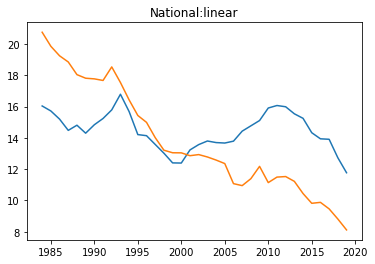

In [167]:
state = 'National'
m_to_plot = new_m_temp_df.loc[new_m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

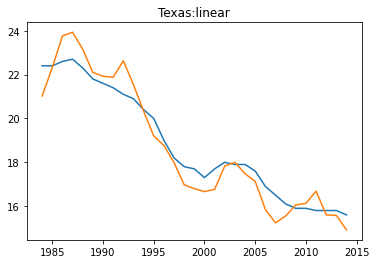

In [168]:
state = 'Texas'
m_to_plot = new_m_temp_df.loc[new_m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

## Not a whole lot better!